## How to use Mathematical Program to formulate optimizations for robots

Before working on this notebook, please go through the `mathematical_program_and_sos_examples.ipynb` from the last problem set. That notebook introduces the API for the `MathematicalProgram` class.

Let's imagine we have a ball that we want to shoot ballistically out of a cannon to a certain point in space.

Our cannon is very sophisticated and let's us choose precisely the intial velocity of the ball, but once the ball has left the cannon, it's out of our control.

We can set up a very simple sim below to simulate this ball.

(1000, 4)


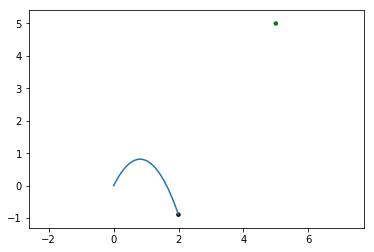

In [1]:
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
from matplotlib.patches import Circle
%matplotlib inline

G = 9.8  # gravity, in m/s^2

def dynamics(state, t):
    ball_position = state[0:2]
    derivs = np.zeros_like(state)
    derivs[0:2] = state[2:4]
    derivs[2]  = 0
    derivs[3]  = -G
    
    return derivs

dt = 0.001
time_array = np.arange(0.0, 1, dt)

state_initial = np.asarray([0, 0, 2, 4])

# integrate using scipy integrate which will do runge-kutta integration probably
state_over_time = integrate.odeint(dynamics, state_initial, time_array)

print state_over_time.shape

ball_position_x = state_over_time[:,0]
ball_position_y = state_over_time[:,1]

fig, axes = plt.subplots(nrows=1,ncols=1)
axes.plot(ball_position_x, ball_position_y)
circ = Circle((ball_position_x[-1],ball_position_y[-1]), radius=0.1, facecolor='k', edgecolor='white', fill=True ,linewidth = 2.0, linestyle='solid')
axes.add_patch(circ)
circ = Circle((5,5), radius=0.1, facecolor='green', edgecolor='white', fill=True ,linewidth = 2.0, linestyle='solid')
axes.add_patch(circ)
axes.axis('equal')
plt.show()

If our goal is to choose the initial velocity so that we make it to the green dot at the top right, then this is a problem we can solve.

This is actually a problem that can be pretty easily solved in closed form, but it's also pretty easy to throw the optimization hammer at the problem.

In [2]:
from pydrake.all import MathematicalProgram, Solve
mp = MathematicalProgram()

velocity_initial = mp.NewContinuousVariables(2, "velocity_initial")
state_initial = np.asarray([0, 0, velocity_initial[0], velocity_initial[1]])

num_time_steps = len(time_array)
states_over_time = np.asarray([state_initial])

for i in range(num_time_steps):
    # Here this just uses euler integration
    state_next = states_over_time[-1,:] + dt*dynamics(states_over_time[-1,:],0)
    states_over_time = np.vstack((states_over_time, state_next))

# Calculate final position error
position_goal = np.asarray([5,5])
final_position_error = position_goal - states_over_time[-1,0:2]

mp.AddQuadraticCost((final_position_error).dot(final_position_error))
result =  Solve(mp)
print result.GetSolution(velocity_initial)
optimal_initial_veloctiy = result.GetSolution(velocity_initial)

[ 5.      9.8951]


[ 0.      0.      5.      9.8951]
(1000, 4)


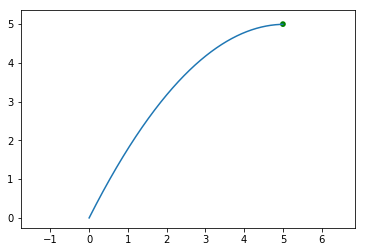

In [3]:
# Simulate given the initial velocity
state = np.asarray([0, 0, optimal_initial_veloctiy[0], optimal_initial_veloctiy[1]])
print state

# We can check our euler integration back against the scipy integration
state_over_time = integrate.odeint(dynamics, state, time_array)
print state_over_time.shape

ball_position_x = state_over_time[:,0]
ball_position_y = state_over_time[:,1]

fig, axes = plt.subplots(nrows=1,ncols=1)
axes.plot(ball_position_x, ball_position_y)
circ = Circle((ball_position_x[-1],ball_position_y[-1]), radius=0.1, facecolor='k', edgecolor='white', fill=True ,linewidth = 2.0, linestyle='solid')
axes.add_patch(circ)
circ = Circle((5,5), radius=0.1, facecolor='green', edgecolor='white', fill=True ,linewidth = 2.0, linestyle='solid')
axes.add_patch(circ)
axes.axis('equal')
plt.show()

In the first example optimization above, we used a quadratic cost on final position error.

What if we just constrain the problem to exactly reach the position?  We can also, for example, add a quadratic cost on the total initial speed of the ball.

In [4]:
from pydrake.all import MathematicalProgram, Solve
mp = MathematicalProgram()

velocity_initial = mp.NewContinuousVariables(2, "velocity_initial")
state_initial = np.asarray([0, 0, velocity_initial[0], velocity_initial[1]])

num_time_steps = len(time_array)
states_over_time = np.asarray([state_initial])

for i in range(num_time_steps):
    state_next = states_over_time[-1,:] + dt*dynamics(states_over_time[-1,:],0)
    states_over_time = np.vstack((states_over_time, state_next))

# Calculate final position error
position_goal = np.asarray([5,5])
final_position_error = position_goal - states_over_time[-1,0:2]

mp.AddQuadraticCost(1 * velocity_initial.dot(velocity_initial))
print position_goal
mp.AddLinearConstraint(states_over_time[-1,0] >= position_goal[0])
mp.AddLinearConstraint(states_over_time[-1,0] <= position_goal[0])
mp.AddLinearConstraint(states_over_time[-1,1] >= position_goal[1])
mp.AddLinearConstraint(states_over_time[-1,1] <= position_goal[1])
result = Solve(mp)
print result.GetSolution(velocity_initial)

[5 5]
[ 5.      9.8951]


[ 0.      0.      5.      9.8951]
(1000, 4)


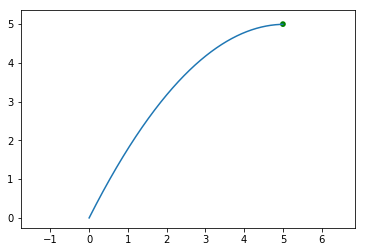

In [5]:
# Simulate given the initial velocity
state = np.asarray([0, 0, optimal_initial_veloctiy[0], optimal_initial_veloctiy[1]])
print state

# We can check our euler integration back against the scipy integration
state_over_time = integrate.odeint(dynamics, state, time_array)
print state_over_time.shape

ball_position_x = state_over_time[:,0]
ball_position_y = state_over_time[:,1]

fig, axes = plt.subplots(nrows=1,ncols=1)
axes.plot(ball_position_x, ball_position_y)
circ = Circle((ball_position_x[-1],ball_position_y[-1]), radius=0.1, facecolor='k', edgecolor='white', fill=True ,linewidth = 2.0, linestyle='solid')
axes.add_patch(circ)
circ = Circle((5,5), radius=0.1, facecolor='green', edgecolor='white', fill=True ,linewidth = 2.0, linestyle='solid')
axes.add_patch(circ)
axes.axis('equal')
plt.show()

## Now what if we have a couple rocket boosters attached?

The problem gets a little bit more interesting if we have a couple of rocket boosters attached to our ball.

We can now ask this problem:

  --> If for the first 100 time steps, we can use the rocket boosters on the ball to adjust its trajectory, then what can we do?

In [6]:
mp = MathematicalProgram()

velocity_initial = mp.NewContinuousVariables(2, "velocity_initial")
state_initial = np.asarray([0, 0, velocity_initial[0], velocity_initial[1]])

num_time_steps = 1000
states_over_time = np.asarray([state_initial])

num_steps_with_boosters = 100

k = 0
u = mp.NewContinuousVariables(2, "u_%d" % k)
u_over_time = u

for k in range(1,num_steps_with_boosters):
    u = mp.NewContinuousVariables(2, "u_%d" % k)
    u_over_time = np.vstack((u_over_time, u))

total_u = np.vstack((u_over_time,np.zeros((900,2))))
    
print "Number of decision vars", mp.num_vars()

states_over_time = np.asarray([state_initial])
def derivs_with_boosters(state, t):
    index = int(t*num_time_steps)
    u = total_u[index]
    rocket_position = state[0:2]
    derivs = np.zeros_like(state)
    derivs[0:2] = state[2:4]
    derivs[2]  = 0 + u[0]
    derivs[3]  = -G + u[1]
    
    return derivs

for i in range(num_time_steps):
    state_next = states_over_time[-1,:] + .001*derivs_with_boosters(states_over_time[-1,:],time_array[i])
    states_over_time = np.vstack((states_over_time, state_next))


# Calculate final position error
position_goal = np.asarray([5,5])
final_position_error = position_goal - states_over_time[-1,0:2]

mp.AddLinearConstraint(velocity_initial[0] <= 20)
mp.AddLinearConstraint(velocity_initial[1] <= 2)

mp.AddQuadraticCost(1 * velocity_initial.dot(velocity_initial))
mp.AddQuadraticCost(1 * u_over_time[:,0].dot(u_over_time[:,0]))
mp.AddQuadraticCost(1 * u_over_time[:,1].dot(u_over_time[:,1]))

mp.AddLinearConstraint(states_over_time[-1,0] >= position_goal[0])
mp.AddLinearConstraint(states_over_time[-1,0] <= position_goal[0])
mp.AddLinearConstraint(states_over_time[-1,1] >= position_goal[1])
mp.AddLinearConstraint(states_over_time[-1,1] <= position_goal[1])
result = Solve(mp)

print "velocity_initial computed", result.GetSolution(velocity_initial)

optimal_initial_veloctiy = result.GetSolution(velocity_initial)
u_over_time = result.GetSolution(u_over_time)
total_u = np.vstack((u_over_time,np.zeros((900,2))))

Number of decision vars 202
velocity_initial computed [ 4.99954885  2.0096322 ]


(1001, 4)


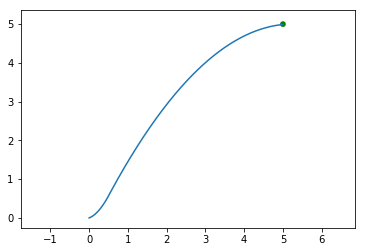

In [7]:
state_initial = np.asarray([0, 0, optimal_initial_veloctiy[0], optimal_initial_veloctiy[1]])

states_over_time = np.asarray([state_initial])
for i in range(num_time_steps):
    state_next = states_over_time[-1,:] + .001*derivs_with_boosters(states_over_time[-1,:],time_array[i])
    states_over_time = np.vstack((states_over_time, state_next))

print states_over_time.shape
    
y = states_over_time

rocket_position_x = y[:,0]
rocket_position_y = y[:,1]

fig, axes = plt.subplots(nrows=1,ncols=1)
axes.plot(rocket_position_x, rocket_position_y)
circ = Circle((rocket_position_x[-1],rocket_position_y[-1]), radius=0.1, facecolor='k', edgecolor='white', fill=True ,linewidth = 2.0, linestyle='solid')
axes.add_patch(circ)
circ = Circle((5,5), radius=0.1, facecolor='green', edgecolor='white', fill=True ,linewidth = 2.0, linestyle='solid')
axes.add_patch(circ)
axes.axis('equal')
plt.show()

# Good luck!

Hopefully that was enough of an initial introduction to help get you started on the orbit transfer problem.

Please ask questions on Piazza and/or come to office hours if you have any more questions.